![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 19 - Kernel trick

En la práctica anterior hemos trabajado con Máquinas de Vectores Soporte tratando de resolver los problemas buscando un hiperplano lineal capaz de separar las clases en el espacio de los atributos o espacio de entrada.

Acabamos la práctica anterior mostrando un conjunto de datos que era imposible separar linealmente aunque pusiésemos valores de `C` muy altos:

![No separable](fig_no_separable.png) 

En esta sesión práctica vamos a ver cómo se puede adaptar el SVM para obtener un buen rendimiento en estos conjuntos que no son separables linealmente en el espacio de entrada.

Vamos, como siempre, a verlo a través de un ejemplo:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

def pinta(X_clase0, X_clase1, texto, espacio_entrada):
    fig, ax = plt.subplots()
    if espacio_entrada == True: 
        # muestra el espacio de entrada
        ax.scatter(X_clase0[:, 0], X_clase0[:, 1], c='r', label='clase 0')
        ax.scatter(X_clase1[:, 0], X_clase1[:, 1], c='b', label='clase 1')
        ax.set_xlabel('x1')
    else: 
        # muestra el espacio de características específico para este caso
        ax.scatter(X_clase0[:, 0]**2, X_clase0[:, 1], c='r', label='clase 0')
        ax.scatter(X_clase1[:, 0]**2, X_clase1[:, 1], c='b', label='clase 1')
        ax.set_xlabel('x1^2')
    ax.set_title(texto)
    ax.set_ylabel('x2')
    ax.legend(loc="lower right")
    ax.grid(True)
    plt.show()

print("\n#####################################################")
print("#### Cargamos conjunto de datos")
print("#####################################################")

df = pd.read_excel('ejemplo.xlsx', sheet_name='datos1')
filas, columnas = df.shape

# separamos las primeras columnas y las almacenamos en X
X = df.iloc[:,0:(columnas-1)]

# separamos la clase
y = df.iloc[:,(columnas-1)]


#####################################################
#### Cargamos conjunto de datos
#####################################################


En el código anterior hemos cargado los datos del ejemplo y hemos definido una función que utilizaremos para representar esos datos de dos formas.

Vamos a visualizar los datos en el espacio de entrada:

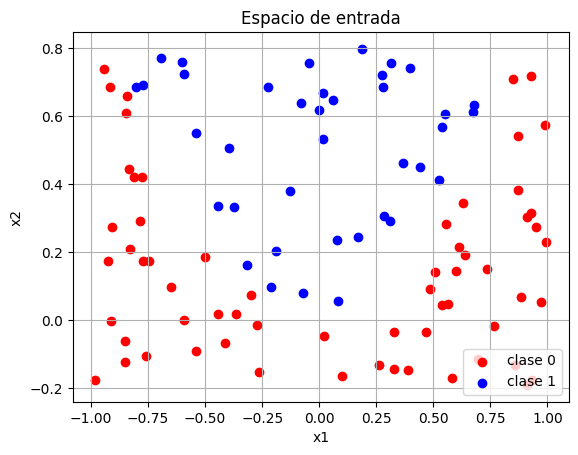

In [3]:
pinta(X[y==0].values, X[y==1].values, 'Espacio de entrada', True)

## 19.1 Espacio de características

Como podemos ver, es imposible trazar una recta que sea capaz de separar los ejemplos de ambas clases sin cometer fallos. Sin embargo, si obtenemos más atributos a partir de los que ya tenemos podríamos representar esos mismos ejemplos en otro espacio donde tal vez sí se puedan separar los ejemplos de manera sencilla. A ese nuevo espacio lo conocemos como **espacio de características** (*feature space*):

$$
\begin{align*}
  \phi \colon \mathbb{R}^d &\to \mathbb{R}^p\\
  x &\mapsto \phi(x)
\end{align*}
$$

La función $\phi$ transforma los ejemplos del espacio de entrada al espacio de características. Así, a partir de un ejemplo $x$ formado por $x_1$ y $x_2$ obtendríamos su transformación al espacio de características $\phi(x)$ que podría estar compuesto por características como $x_1^2$, $x_2^2$ o $x_1x_2$.

Veamos qué pasa en el conjunto de datos anterior si en lugar de representar los ejemplos en el espacio de entrada, donde $x=(x_1,x_2)$, lo representamos en el espacio de características $\phi(x)=(x_1^2,x_2)$:

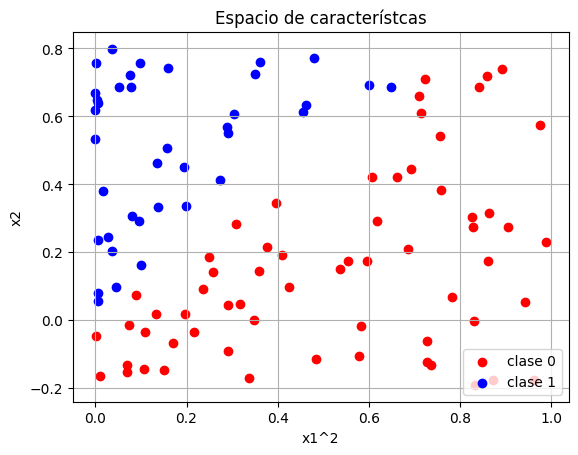

In [4]:
pinta(X[y==0].values, X[y==1].values, 'Espacio de característcas', False)

Ahora todos seríamos capaces de trazar la recta que separa ambas clases y si a la SVM le presentásemos los ejemplos de esta manera, no tendría dificultad para encontrar el hiperplano que mejor separa las clases maximizando el margen.

Lo que hemos hecho ha sido proyectar los ejemplos en un nuevo espacio donde es más sencillo separalos linealmente. Hemos transformado los ejemplos añadiéndoles atributos que se basan en los atributos que ya conocemos. Problemas:
1. Normalmente no conoceremos cuál es la transformación necesaria o cuáles son las combinaciones entre los atributos necesarias para que el espacio de características sea útil.
2. Si decidimos que queremos elevar al cuadrado y al cubo todos los atributos y que además queremos multiplicar unos atributos con otros para generar nuevos atributos, nos encontramos con que tenemos que realizar muchos cálculos y además es posible que el número de atributos sea tan grande que sea difícil almacenar todos los datos.

Por ejemplo, si tenemos un conjunto en el que los ejemplos se definen con tres atributos $x=(x_1,x_2,x_3)$ y queremos calcular los atributos comentados anteriormente (sin calcular los cubos), nos encontraríamos con el siguiente espacio de características: $\phi(x)=(x_1,x_2,x_3,x_1^2,x_2^2,x_3^2,x_1x_2,x_1x_3,x_2x_3,x_1x_2^2,x_1x_3^2,x_2x_1^2,x_2x_3^2,x_3x_1^2,x_3x_2^2,x_1^2x_2^2,x_1^2x_3^2,x_2^2x_3^2)$. Hemos pasado de 3 atributos a 18 características. Ahora imaginad cómo podría ser el espacio de características si también incorporamos los cubos y si en lugar de haber 3 atributos en el espacio de entrada hubiese 10. El crecimiento es exponencial.

## 19.2 Kernel trick (o truco del kernel)

En la sesión anterior vimos que una SVM lineal aprende una función como:

$$
f(z)=w^T z + b = \left( \sum^n_{i=1} \alpha^{(i)} y^{(i)} x^{(i)} \right)^T z + b = \sum^n_{i=1} \alpha^{(i)} y^{(i)} \langle x^{(i)}, z \rangle + b 
$$

donde $z$ es el ejemplo que se quiere valorar y $x^{(i)}$ es uno de los $n$ ejemplos del conjunto de entrenamiento. Si observamos la ecuación, vemos que lo que nos interesa es poder calcular el producto escalar de $z$ con los ejemplos de entrenamiento $\langle x^{(i)}, z \rangle$.

El truco del kernel consiste en ser capaces de calcular el producto escalar entre $z$ y $x$ en el espacio de características sin proyectar ni $z$ ni $x$ en ese espacio. Y eso es lo que hace la función kernel $k\left( x, z \right)=\langle \phi(x), \phi(z) \rangle$:

$$
f(z)=w^T z + b = \sum^n_{i=1} \alpha^{(i)} y^{(i)} \langle x^{(i)}, z \rangle + b =  \sum^n_{i=1} \alpha^{(i)} y^{(i)} \langle \phi(x^{(i)}), \phi(z) \rangle + b = \sum^n_{i=1} \alpha^{(i)} y^{(i)} K\left( x^{(i)}, z \right) + b 
$$

Por tanto, ahora necesitamos encontrar funciones kernel que nos permitan calcular el producto escalar de dos vectores en un espacio de características sin necesidad de calcular explícitamente esas características.

### 19.2.1 Kernel lineal

El kernel lineal es el kernel con el que estuvimos trabajando en la práctica anterior. 

En este caso, el espacio de entrada es igual al espacio de características $\phi(x)=x$ y, por tanto, $K\left( x, z \right)=\langle x, z \rangle$.

Para utilizar ester kernel es necesario utilizar el hiperparámetro `kernel='linear'`: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

### 19.2.2 Kernel polinómico

Si tenemos que $x=(x_1,x_2)$ y creemos que la solución a nuestro problema puede obtenerse más fácilmente elevando los atributos al cuadrado y multiplicando unos atributos por otros, entonces nos gustaría tener un espacio de características en el que $\phi(x)=(x_1,x_2,x_1^2,x_2^2,x_1x_2)$. 

El kernel polinómico calcula el producto escalar de dos vectores en un espacio de característacas similar al que acabamos de describir: https://en.wikipedia.org/wiki/Polynomial_kernel 

Para lograrlo realiza el siguiente cálculo: 
$$
K(x,z)=\left(\langle x, z \rangle + c \right)^d
$$

Para utilizar este kernel en el `SVC` debemos tener en cuenta los siguientes hiperparámetros:
- `kernel='poly'`
- `degree` se refiere al grado $d$ al que se eleva la ecuación anterior
- `coef0` se refiere al término $c$ de la ecuación anterior. Vamos a ver qué importancia tiene en el espacio de características.

Imaginemos que queremos calcular $K(x,z)=\left(\langle x, z \rangle + 0 \right)^2$ siendo el espacio de entrada de 2 dimensiones:

$$
K(x,z)=\left(\langle x, z \rangle\right)^2 = \left(x_1z_1 + x_2z_2\right)^2 = x_1^2z_1^2 + x_2^2z_2^2 + 2x_1z_1x_2z_2 = \langle \left(x_1^2, x_2^2,\sqrt{2}x_1x_2\right), \left(z_1^2, z_2^2,\sqrt{2}z_1z_2\right) \rangle =\langle \phi(x), \phi(z) \rangle
$$

Como vemos $\phi(x)=\left(x_1^2, x_2^2,\sqrt{2}x_1x_2\right)$, con lo que hemos perdido los atributos originales. Veamos qué solución aportaría este kernel:

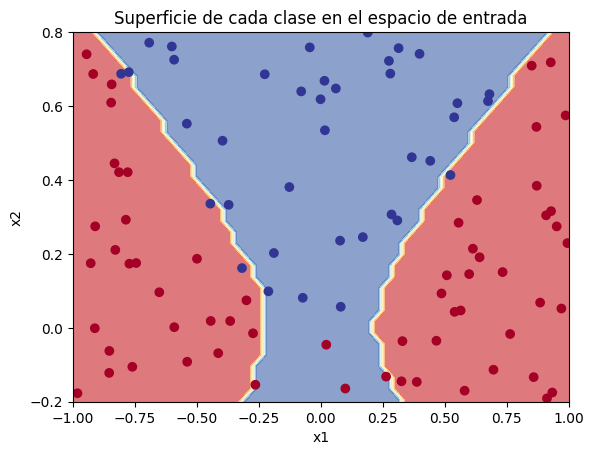

In [5]:
# creamos una SVM con kernel polinómico de grado 2 con coef0=0
sys_svc = SVC(kernel='poly', degree=2, coef0=0)

# entrenamos
sys_svc.fit(X,y)

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_svc, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([-1, 1])
disp.ax_.set_ylim([-0.2, 0.8])
disp.ax_.set_title('Superficie de cada clase en el espacio de entrada')
plt.show()

La solución es buena, pero no perfecta. Al principio de la práctica vimos que si utilizamos $(x_1^2,x_2)$ las clases eran fácilmente separables, así que al no contar con $x_2$ en el espacio de caractrísticas estamos dificultando la tarea de la SVM.

Vamos a calcular ahora $K(x,z)=\left(\langle x, z \rangle + 1 \right)^2$:

$$
\begin{align*}
K(x,z) \left(x_1z_1 + x_2z_2 + 1\right)^2 &= x_1^2z_1^2 + x_2^2z_2^2 + 1^2 + 2x_1z_1x_2z_2 + 2x_1z_11 + 2x_2z_21 \\
&= \langle \left(x_1^2, x_2^2, 1, \sqrt{2}x_1x_2, \sqrt{2}x_1, \sqrt{2}x_2 \right), \left(z_1^2, z_2^2, 1, \sqrt{2}z_1z_2, \sqrt{2}z_1, \sqrt{2}z_2\right) \rangle =\langle \phi(x), \phi(z) \rangle
\end{align*}
$$

Utilizando `coef0=1` ya no perdemos los atributos originales. Veamos la solución que obtenemos con este kernel:

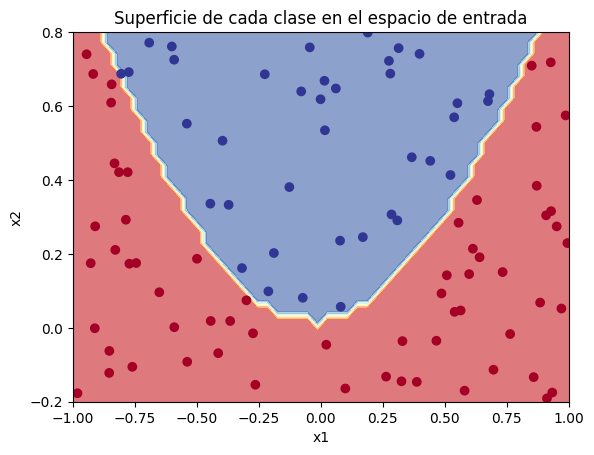

In [6]:
# creamos una SVM con kernel polinómico de grado 2 con coef0=1
sys_svc = SVC(kernel='poly', degree=2, coef0=1)

# entrenamos
sys_svc.fit(X,y)

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_svc, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([-1, 1])
disp.ax_.set_ylim([-0.2, 0.8])
disp.ax_.set_title('Superficie de cada clase en el espacio de entrada')
plt.show()

Ahora sí obtenemos la mejor solución.

Cuando utilizamos el kernel polinómico es habitual fijar `coef0=1` y probar varios valores para `degree`.

### 19.2.3 Kernel RBF

El kernel RBF (Radial Basis Function) es un kernel muy utilizado por su capacidad de adaptación a todo tipo de problemas. Se calcula mediante la siguiente fórmula:
$$
K(x,z)=\exp\left(- \frac{\lVert x - z \rVert^2}{2\sigma^2} \right)
$$

Si definimos $\gamma = \frac{1}{2\sigma^2}$, entonces obtendremos la siguiente fórmula para refereirnos al kernel RBF:
$$
K(x,z)=\exp\left(-\gamma\lVert x - z \rVert^2\right)
$$

El espacio de características en el que se calcula el producto escalar es un espacio infinito que no puede ser calculado ni representado, pero sí se puede calcular su producto escalar utilizando este kernel.

Para utilizar este kernel en el `SVC` debemos tener en cuenta los siguientes hiperparámetros:
- `kernel='rbf'`
- `gamma` debe ser un valor en el rango $(0,inf)$

Veamos qué solución propone SMV con kernel RBF y `gamma` por defecto:

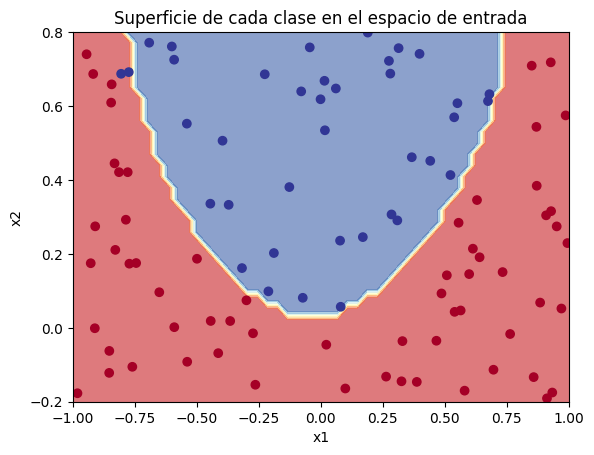

In [7]:
# creamos una SVM con kernel rbf con gamma por defecto
sys_svc = SVC(kernel='rbf')

# entrenamos
sys_svc.fit(X,y)

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_svc, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([-1, 1])
disp.ax_.set_ylim([-0.2, 0.8])
disp.ax_.set_title('Superficie de cada clase en el espacio de entrada')
plt.show()

La solución es bastante buena y seguro que buscando valores óptimos para los hiperparámetros `gamma` y `C` podríamos alcanzar una mejor solución.

Vamos ahora a proponerle una tarea un poco más complicada, donde los ejemplos de una de las clases se encuentren concentrados en dos zonas del espacio de entrada:

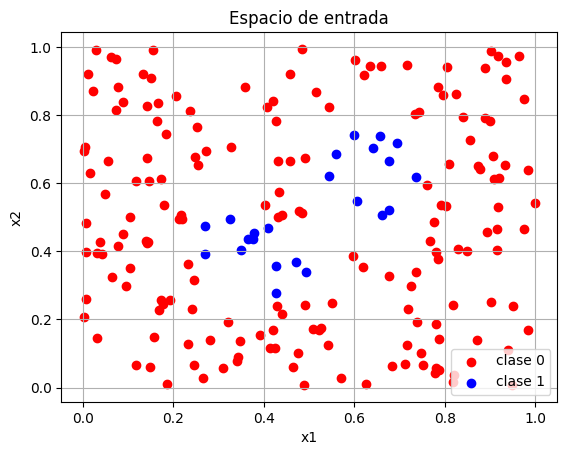

In [8]:
df = pd.read_excel('ejemplo.xlsx', sheet_name='datos2')
filas, columnas = df.shape

# separamos las primeras columnas y las almacenamos en X
X = df.iloc[:,0:(columnas-1)]

# separamos la clase
y = df.iloc[:,(columnas-1)]

pinta(X[y==0].values, X[y==1].values, 'Espacio de entrada', True)

La tarea no es sencilla ya que hay muchos más ejemplos de la clase 0 y los ejemplos de la clase 1 están separados en dos grupos.

Vamos a ver qué sucede si variamos la `gamma`: 

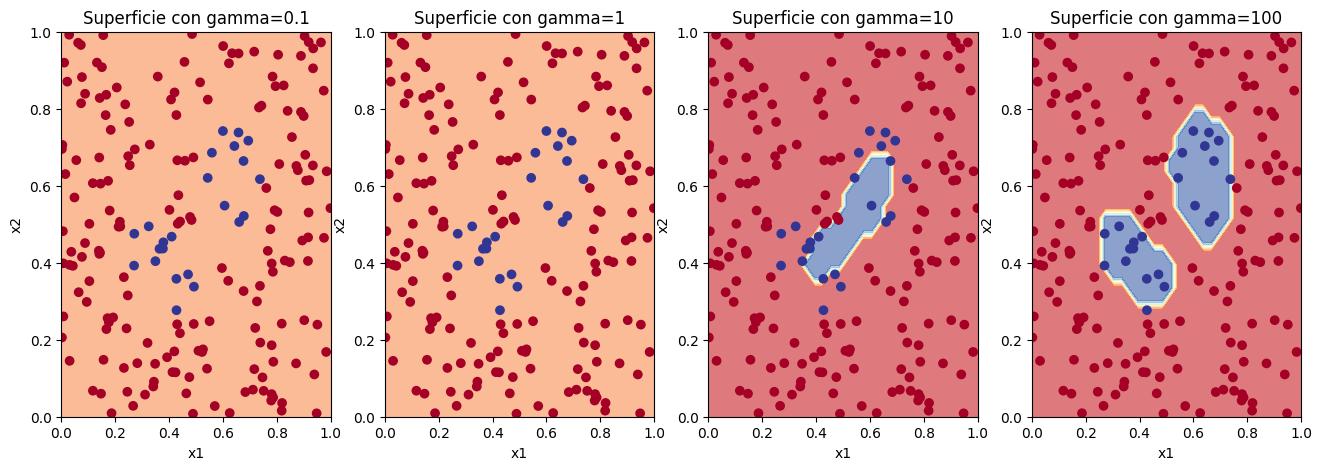

In [9]:
# creamos una SVM con kernel rbf con gamma por defecto
sys_svc = SVC(kernel='rbf')

# creamos una figura con 4 gráficas
fig, sub = plt.subplots(1, 4)
fig.set_size_inches(16, 5)

col = 0
for g in [0.1, 1, 10, 100]:
    sys_svc.set_params(gamma=g)  # cambiamos la gamma
    sys_svc.fit(X,y)             # entrenamos

    disp = DecisionBoundaryDisplay.from_estimator(sys_svc, X, response_method="predict", cmap=plt.cm.RdYlBu, 
        ax=sub[col], alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])
    sub[col].set_xlim([0, 1])
    sub[col].set_ylim([0, 1])
    sub[col].scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)
    #sub[col].scatter(sys_svc.support_vectors_[:,0], sys_svc.support_vectors_[:,1], s=100, facecolors='none', edgecolors='k')
    sub[col].set_title('Superficie con gamma='+str(g))
    col = col + 1

Cuanto mayor sea el valor de `gamma` más se ajustará el modelo a los datos. Ahora debemos tener cuidado con los valores que utilicemos para `gamma` y para `C` porque corremos riesgo de sobreajustarnos:

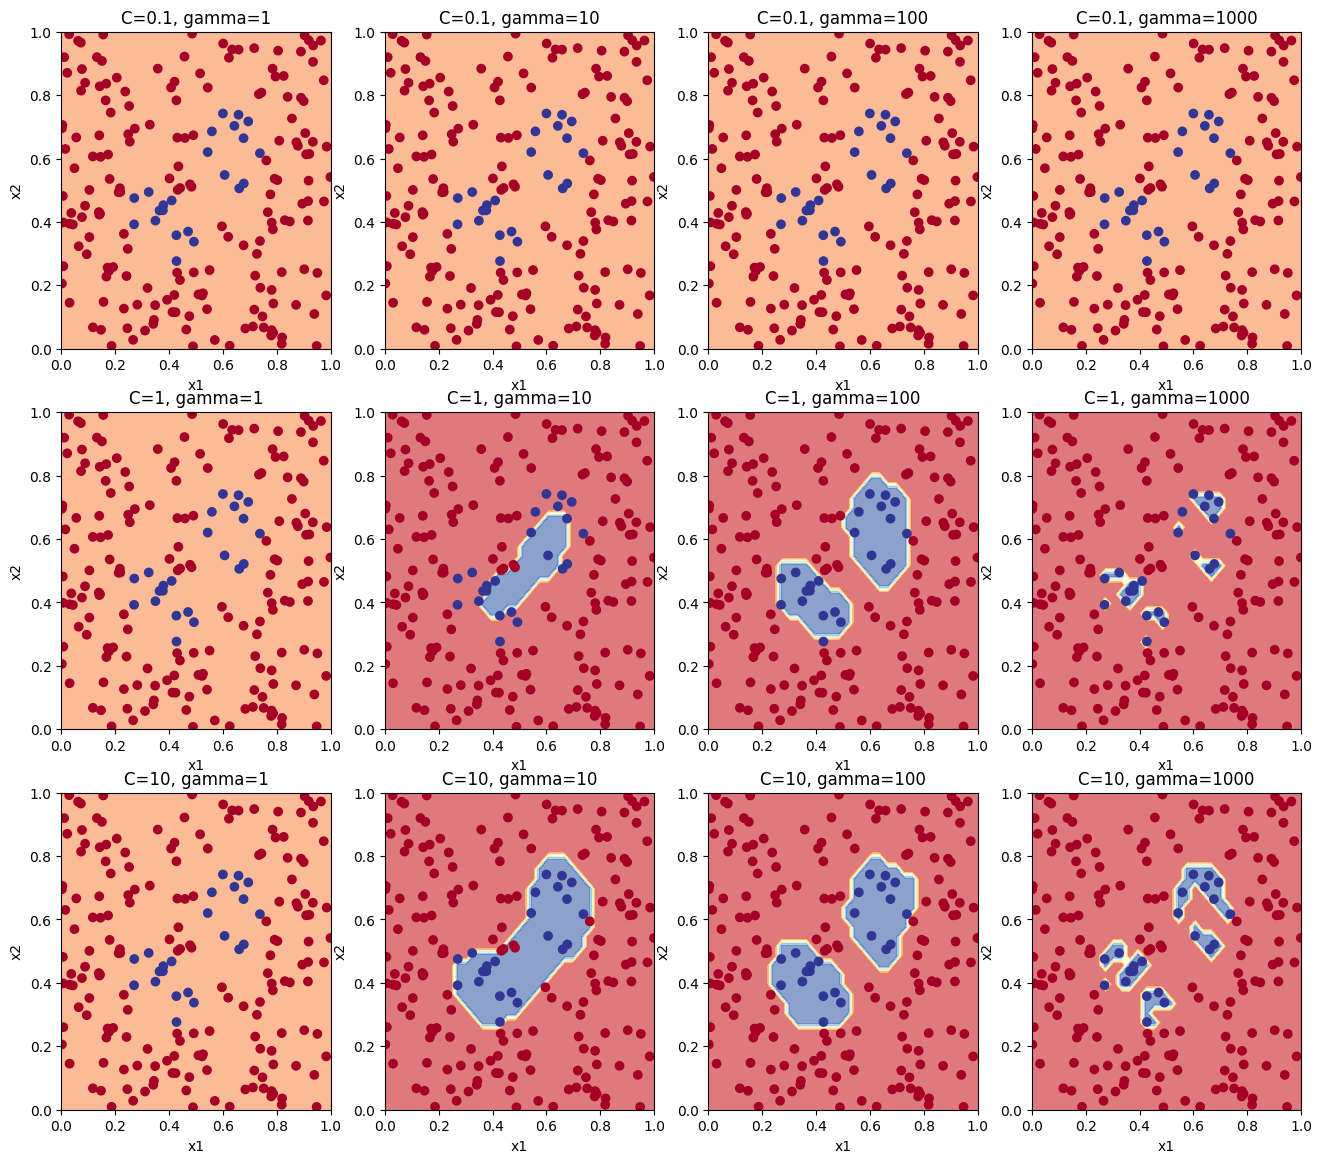

In [10]:
# creamos una SVM con kernel rbf con gamma por defecto
sys_svc = SVC(kernel='rbf')

# creamos una figura con 4 gráficas
fig, sub = plt.subplots(3, 4)
fig.set_size_inches(16, 14)

fila = 0
for c in [0.1, 1, 10]:
    sys_svc.set_params(C=c)  # cambiamos la C
    col = 0
    for g in [1, 10, 100, 1000]:
        sys_svc.set_params(gamma=g)  # cambiamos la gamma
        sys_svc.fit(X,y)             # entrenamos

        disp = DecisionBoundaryDisplay.from_estimator(sys_svc, X, response_method="predict", cmap=plt.cm.RdYlBu, 
            ax=sub[fila][col], alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])
        sub[fila][col].set_xlim([0, 1])
        sub[fila][col].set_ylim([0, 1])
        sub[fila][col].scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)
        #sub[fila][col].scatter(sys_svc.support_vectors_[:,0], sys_svc.support_vectors_[:,1], s=100, facecolors='none', edgecolors='k')
        sub[fila][col].set_title('C='+str(c)+', gamma='+str(g))
        col = col + 1
    fila = fila + 1

Vemos que valores altos de `C` y `gamma` pueden llevarnos a soluciones que claramente están sobreajustadas.

### 19.2.4 Otros kernels

Los kernels lineal, polinómico y RBF son los más utilizados.

Sin embargo, existen otros kernels o incluso tenemos la posibilidad de crear nosotros nuestros propios kernels:

- https://scikit-learn.org/stable/modules/svm.html#svm-kernels 
- https://en.wikipedia.org/wiki/String_kernel
- https://en.wikipedia.org/wiki/Fisher_kernel
- https://en.wikipedia.org/wiki/Kernel_smoother
- ...



## Ejercicios

1. Carga el fichero **ionosphere.data** (es un archivo de texto). 
2. Prueba los kernels polinómico y RBF (prueba diferentes valores para los hiperparámetros `C`, `degree` y `gamma`).
3. Busca los mejores valores para los hiperparámetros y evalúa el rendimiento final del modelo (utiliza una `GridSearchCV` dentro de una validación cruzada como se vio en la sesión 11). 

Estos ejercicios no es necesario entregarlos.